# Ensemble Learning

In this chapter we will learn about followings:-

- Make predictions on majority voting.
- Use bagging to reduce overfitting by drawing random combinations of the training set with repetition
- Apply boosting to build powerful models from *weak learners* that learn from their mistakes

## Learning with ensembles

The goal of **ensemble methods** is to combine different classifiers into a meta-classifier that has better generalization performance than each individual classifier alone.

**Majority Voting** - It simply means that we select the class label that has been predicted by the majority of classifiers, i.e, received more than 50% of the votes. Also the term *majority voting* referes to binary classes only. However it is easy to generalize the majority voting priniciple to multi-class setting, which is called **plurality voting**. (here we select the class label that received the most vote(mode)).

*Ensemble can be done by combining different classifier models or by using same collection of models and training them with different subsets of training set.*

## Combining classifiers via majority vote (also plurality voting)

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder


In [3]:
iris = datasets.load_iris()

In [4]:
X, y = iris.data[50:, [1,2]], iris.target[50:]

In [5]:
le = LabelEncoder()
y = le.fit_transform(y)

In [6]:
np.unique(y)

array([0, 1], dtype=int64)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.5, random_state = 1, stratify = y)

In [8]:
#lets train three classifier, logistic regression, decision tree, k-nearest neighbors
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline

In [9]:
clf1 = LogisticRegression(
        penalty='l2',
        C = 0.001,
        random_state = 1
)

clf2 = DecisionTreeClassifier(
            max_depth=1,
            criterion='entropy',
            random_state=0
)

clf3 = KNeighborsClassifier(
        n_neighbors=1,
        p = 2,
        metric='minkowski'
)

In [10]:
pipe1 = make_pipeline(StandardScaler(), clf1)

In [11]:
pipe2 = make_pipeline(StandardScaler(), clf3)

In [12]:
import warnings
warnings.filterwarnings('ignore')

clf_labels = ['Logistic Regression', 'Decision Tree', 'KNN']


for  label, clf in zip(clf_labels, [pipe1, clf2, pipe2]):
    scores = cross_val_score(estimator=clf, X=X_train, y=y_train, cv=10, scoring='roc_auc')
    
    print("ROC AUC: {:.2f} (+/- {:.2f}) {}".format(np.mean(scores), np.std(scores), label))
    

ROC AUC: 0.87 (+/- 0.17) Logistic Regression
ROC AUC: 0.89 (+/- 0.16) Decision Tree
ROC AUC: 0.88 (+/- 0.15) KNN


In [13]:
from sklearn.ensemble import VotingClassifier

In [14]:
en = VotingClassifier(
    estimators=[('m1',pipe1),('m2',clf2),('m3',pipe2)],
    voting='soft'
)

In [15]:
clf_labels  += ['Ensemble']

In [16]:
for label, clf in zip(clf_labels, [pipe1, clf1, pipe2, en]):
    scores = cross_val_score(estimator=clf, scoring='roc_auc', cv = 10, X = X_train, y = y_train)
    print("ROC AUC: {:.2f} (+/- {:.2f}) {}".format(np.mean(scores), np.std(scores), label))

ROC AUC: 0.87 (+/- 0.17) Logistic Regression
ROC AUC: 0.97 (+/- 0.10) Decision Tree
ROC AUC: 0.88 (+/- 0.15) KNN
ROC AUC: 0.94 (+/- 0.13) Ensemble


As we can observe above our ensemble model perform better than any individual model

## Evaluating and tuning the ensemble classifier

Here we will check how good our model generalizes over an unseen data (test data)

In [17]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

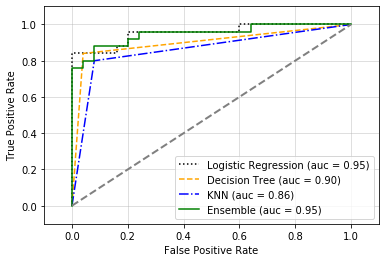

In [18]:
all_clf = [pipe1, clf2, pipe2, en]

colors = ['black', 'orange', 'blue', 'green']
linestyles = [':', '--', '-.', '-']

for clf, label, clr, ls in zip(all_clf, clf_labels, colors, linestyles):
    #assuming the label of positive class is 1 remember that roc curve is tpr vs fpr
    probas = clf.fit(X_train, y_train).predict_proba(X_test)[:,1]
    fpr, tpr, threshods = roc_curve(y_true=y_test, y_score=probas)
    
    roc_auc = auc(x=fpr, y = tpr)
    
    plt.plot(fpr, tpr, color = clr, linestyle=ls, label = '{} (auc = {:.2f})'.format(label, roc_auc))

plt.legend(loc = 'lower right')
plt.plot([0,1],[0,1], linestyle = '--', color = 'gray', linewidth = 2)
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.grid(alpha = 0.5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

As we can observe in the resulting ROC, the ensemble also performs well on the test set (ROC AUC = 0.95). Also we can observe that the logistic regression classifier performs similary well on the same dataset, which is probably due to the high variance (in this case senstivity of how we split the dataset) given small size of the dataset

In [19]:
#we will standarize our data for visualization to be on same scale even though our pipeline see it for the two models.
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)

from itertools import product #it does cross product / cartesian product

x1_min, x1_max = X_train_std[:,0].min() - 1, X_train_std[:,0].max() + 1
x2_min, x2_max = X_train_std[:,1].min() - 1, X_train_std[:,1].max() + 1

xx1, xx2  = np.meshgrid(
            np.arange(x1_min, x1_max , 0.1),
            np.arange(x2_min, x2_max, 0.1)
)

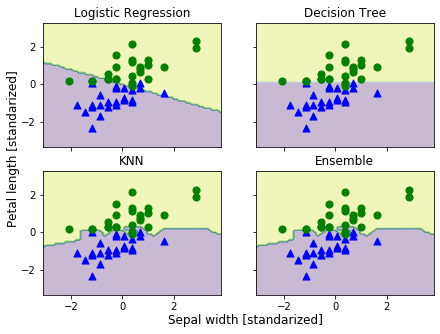

In [20]:
#let's make subplots for our 2 X 2 figure first

fig, axis = plt.subplots(ncols=2, nrows=2, sharex='col', sharey='row' ,figsize = (7,5))

for idx, clf, tt in zip(product([0,1],[0,1]), all_clf, clf_labels):
    clf.fit(X_train_std, y_train) #fitting our model
    
    Z = clf.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    
    #since tt is a tupe with (x, y)
    axis[idx[0], idx[1]].contourf(xx1, xx2, Z, alpha = 0.3)
    axis[idx[0], idx[1]].scatter(X_train_std[y_train==0, 0], X_train_std[y_train==0, 1], c = 'blue', marker = '^', s = 50)
    axis[idx[0], idx[1]].scatter(X_train_std[y_train==1,0], X_train_std[y_train==1, 1], c = 'green', marker = 'o', s = 50)
    axis[idx[0], idx[1]].set_title(tt)

plt.text(-3.5, -4.7, s = 'Sepal width [standarized]', ha = 'center', va = 'center', fontsize = 12)
plt.text(-12.5, 4.5, s = 'Petal length [standarized]', ha = 'center', va = 'center', fontsize = 12, rotation = 90)
plt.show()

As we can observe in the above figure the decision boudary made by our ensemble classifier looks like hybrid of individual classifier.

In [21]:
#let's tune this ensemble model, but for that first let's know what the variable get called
en.get_params()

{'estimators': [('m1', Pipeline(memory=None,
            steps=[('standardscaler',
                    StandardScaler(copy=True, with_mean=True, with_std=True)),
                   ('logisticregression',
                    LogisticRegression(C=0.001, class_weight=None, dual=False,
                                       fit_intercept=True, intercept_scaling=1,
                                       l1_ratio=None, max_iter=100,
                                       multi_class='warn', n_jobs=None,
                                       penalty='l2', random_state=1, solver='warn',
                                       tol=0.0001, verbose=0, warm_start=False))],
            verbose=False)),
  ('m2',
   DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=1,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
  

In [22]:
from sklearn.model_selection import GridSearchCV

In [23]:
params = {
    'm1__logisticregression__C': [0.001, 0.1, 100.0],
    'm2__max_depth':[1,2]
}

In [24]:
grid = GridSearchCV(estimator=en, cv=10, scoring='roc_auc', param_grid=params)

In [25]:
grid.fit(X_train, y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=VotingClassifier(estimators=[('m1',
                                                     Pipeline(memory=None,
                                                              steps=[('standardscaler',
                                                                      StandardScaler(copy=True,
                                                                                     with_mean=True,
                                                                                     with_std=True)),
                                                                     ('logisticregression',
                                                                      LogisticRegression(C=0.001,
                                                                                         class_weight=None,
                                                                                         dual=False,
                           

In [26]:
grid.best_score_

0.9733333333333334

In [27]:
grid.best_params_

{'m1__logisticregression__C': 100.0, 'm2__max_depth': 1}

# Bagging

In Bagging instead of using the same training set to fit the individual classifiers in the ensemble, we draw *bootstrap samples* (with replacement, can also carry some duplicates) from the initial training set, which is why bagging is also know as **Bootstrap Aggregatror**. 

Aggregator here means that we club the result from individual classifier in ensemble to make the decision bacially voting.

*Note:- Random Forest is a special case of Bagging where we also use random feature subsets for fitting the individual decision trees*

**Bagging can improve the accuracy of unstable models and decrease the degree of overfitting**<br>

By default bagging models have low bias and low variance, so bagging is good for complex model that get overfitted easily

In [28]:
import pandas as pd

In [29]:
df_wine = pd.read_csv('wine.data', header = None)

In [30]:
df_wine.columns = [
    'class label',
    'Alcohol',
    'Malic Acid',
    'Ash',
    'Alcalinity of ash',
    'Magnesium',
    'Total phenols',
    'Flavanoids',
    'Nonflavanoid phenols',
    'Proanthocyanins',
    'Color intensity',
    'Hue',
    '0D280/0D315 of diluted wines',
    'Proline'
]

In [31]:
df_wine.head()

,class label,Alcohol,Malic Acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,0D280/0D315 of diluted wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [35]:
#here we will only consider wine class 2 and 3
df_wine = df_wine[df_wine['class label'] != 1]

#here we will only consider two features Alochol, OD280/0D315 of diluted wines
y = df_wine['class label'].values
X = df_wine[['Alcohol', '0D280/0D315 of diluted wines']].values

In [36]:
#let's label encode our class labels
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

y = le.fit_transform(y)

In [39]:
np.bincount(y), np.unique(y)

(array([71, 48], dtype=int64), array([0, 1], dtype=int64))

In [40]:
#let's split our data in 80:20 ration for training and testing set
from sklearn.model_selection import train_test_split

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1, stratify = y)

In [44]:
from sklearn.ensemble import BaggingClassifier

In [45]:
#we will be using decision tree with no pruning for our Bagging classifier
tree = DecisionTreeClassifier(
        criterion='entropy',
        random_state = 1,
        max_depth = None
)

In [50]:
'''
    Here, we will be making 500 estimator,
    each estimator will train for randomly sample with replacement (Bootstrap = True),
    each estimator will train for all feature without replacement (Bootstrap = False)
    
    See Bagging Classifier doc for understanding max_sample
    and max_feature, it is differnt for int value and flaot value
    for int, max_feature means max_feature for sampling.
    For float, max_feature means max_feature * X.shape[1] for sampling
    similary for max_sample
    for int; max_sample
    for Float; max_sample * X.shape[0]

'''


bag = BaggingClassifier(
        base_estimator=tree,
        n_estimators=500,
        max_samples=1.0,
        max_features=1.0,
        bootstrap=True,
        bootstrap_features=False,
        n_jobs=-1,
        random_state=1
)

In [51]:
from sklearn.metrics import accuracy_score

In [52]:
tree  = tree.fit(X_train, y_train) #fitting our decision tree first

In [56]:
y_train_pred = tree.predict(X_train) #how model perform on already seen data
y_test_pred = tree.predict(X_test)   #how model perform on unseen data

tree_training_set_accuracy = accuracy_score(y_pred=y_train_pred, y_true=y_train)
tree_testing_set_accuracy = accuracy_score(y_pred=y_test_pred, y_true=y_test)

print('Decision tree test/train score {:.3f}/{:.3f}'.format(tree_training_set_accuracy, tree_testing_set_accuracy))

Decision tree test/train score 1.000/0.833


Remeber that we don't used pruning for our decision tree, it will resulting in maximum depth tree it means it capture ever details of data and make the model complex. It can be observed from the accuray score that our model is overfitted, 100% score for training set and only 83% for testing set. Thus our model have high variance.

Now let's see how our bagging model with same base estimator performs

In [57]:
bag.fit(X_train, y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None,
                                                        criterion='entropy',
                                                        max_depth=None,
                                                        max_features=None,
                                                        max_leaf_nodes=None,
                                                        min_impurity_decrease=0.0,
                                                        min_impurity_split=None,
                                                        min_samples_leaf=1,
                                                        min_samples_split=2,
                                                        min_weight_fraction_leaf=0.0,
                                                        presort=False,
                                                        random_state=1,
                                                        splitter='best'),
    

In [58]:
y_train_pred = bag.predict(X_train)
y_test_pred = bag.predict(X_test)

bag_training_set_accuracy = accuracy_score(y_true=y_train, y_pred=y_train_pred)
bag_testing_set_accuracy  = accuracy_score(y_true=y_test, y_pred = y_test_pred)

print('Bagging train/test accuracies: {:.3f}/{:.3f}'.format(bag_training_set_accuracy, bag_testing_set_accuracy))

Bagging train/test accuracies: 1.000/0.917


We can observe that bagging classifier perfrom much better than single Decision tree, although both have training accuracy as 100%, bagging also perform better on testing set with accuracy of 91.7% which is more than Decision Tree. Thus our variance of bagging classifier is by default less. (Bagging classifier generalizes better)

In [59]:
#let's see decision region for both the models

x1_min, x1_max = X_train[:,0].min() - 1, X_train[:,0].max() + 1
x2_min, x2_max = X_train[:,1].min() - 1, X_train[:,1].max() + 1

xx1, xx2 = np.meshgrid(
                np.arange(x1_min, x1_max, 0.1),
                np.arange(x2_min, x2_max, 0.1)
)

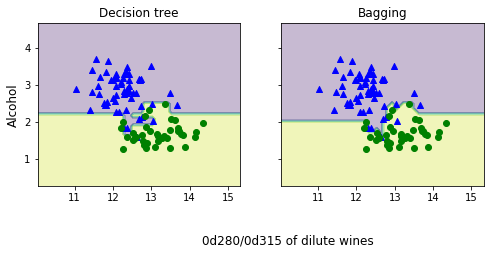

In [61]:
fig, ax = plt.subplots(nrows=1, ncols=2, sharex='col', sharey='row', figsize = (8,3))

for idx, clf, tt in zip([0,1], [tree, bag], ['Decision tree', 'Bagging']):
    Z = clf.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    
    ax[idx].contourf(xx1, xx2, Z, alpha = 0.3)
    ax[idx].scatter(X_train[y_train == 0, 0], X_train[y_train==0, 1], c = 'blue', marker = '^')
    ax[idx].scatter(X_train[y_train == 1, 0], X_train[y_train == 1,1], c = 'green', marker = 'o')
    ax[idx].set_title(tt)

ax[0].set_ylabel('Alcohol', fontsize = 12)
plt.text(10.2, -1.2, s = '0d280/0d315 of dilute wines', ha = 'center', va = 'center', fontsize = 12)
plt.show()

We can observe from the above diagram that decison boundary is more smoother in bagging classifier than in Decision tree thus our Bagging generalize better than decision tree on unseen data.

**Note :-**
The bagging algorithm can be an effective approach to reduce the variance of a model. However bagging is ineffective in reducing model bias, i.e models that are too simple to capture the trend in the data well. This is why we want to perform bagging on ensembe of classifiers with low bias(Decision tree), for example unpruned decision tree.

# AdaBoost (Adaptive Boosting)

**Making Weak learner into Strong Learner**

In boosting, the ensemble consists of very simple base classifiers, also often referred to as **weak learners**, which often only have a slight performance advantage over random guessing - a typical example of a weak learner is a decision tree stump.

**Decision Tree Stump** - It is a one level decision tree. i.e a decision tree with one internal nodes which is immediately connect to the terminal nodes. A decision stumps make a predicition based on the values of just a single input feature. Basically a stump is tree with one node and two leaves

The key concept behind boosting is to focus on training samples that are hard to classify, i.e, to let the weak learners subsequentally learn from misclassified training samples to improve the performance of the ensemble.

**Idea behind AdaBoost**

- AdaBoost combines a lot of **weak learners** to make classifications. The weak learner are always stumps (Decision Stump)
- Some stump get more say (Amount of say) in the classification than others.
- Each stump is made by taking the previous stumps mistakes into account.

**Basic different b/w Adaboost and other ensemble model**

- In other ensemble model every estimator has an equal weightage on voting for classification, but in adaboost some estimator (Decision stump) has more weightage on the vote.
- Also order of implementation of estimator is important in adaboost because the error that the first stump makes influences how the second stump is made and so on. On the other hand the order of implementation if not important in other ensemble model.

**Note-**<br>
Boosting can lead to decrease in bias as well as variance compared to bagging models. In practice however, boosting algorithms such as AdaBoost are also known for their high variance, i.e, the tendancy to overfit the training data.

**Steps in AdaBoost**

1. Assign equal weight to each sample that will be equal to $ \frac {1} {Total Number of samples} $


2. Calculate Total Error for misclassified sample by the model.  $ TE = \sum _{j=1} ^{j=m} w _j $
    
    here, m is total number of misclassified sample <br> $ w _j $ is weight of each misclassified sample
    
 
3. Calculate Weighted Error rate $ \alpha _j $ (also called as Amount of say)  $ \alpha _j = \frac {1} {2} \log \frac {1-TE} {TE} $


4. Now we will update the weight for each sample

    For Misclassified sample, $ New Weight = Weight * e ^{Amount of Say} $, It will increase the weight for misclassified sample<br>
    For Correct classif. sample, $ New Weight = Weight * e ^ {Amount of Say} $, It will decrease the weight for correct classified sample.
    
    
5. We will normalize the weight so that it added to 1. $ w = \frac {w} {\sum w} $

6. Compute the final prediction: $ ypred = (\sum _{j=1} ^{m} (\alpha _j * predict(C _j, X)) > 0) $, m is the total number of samples.
 

In [62]:
from sklearn.ensemble import AdaBoostClassifier

In [64]:
#let's use Decision tree for our base estimator, remeber decision stump

tree = DecisionTreeClassifier(
        criterion='entropy',
        random_state =1 ,
        max_depth = 1

)

In [65]:
ada = AdaBoostClassifier(
        base_estimator=tree,
        n_estimators=500,
        learning_rate=0.1,
        random_state=1
)

In [66]:
#let's train our tree model for comparison 
tree = tree.fit(X_train, y_train)

In [68]:
y_train_pred = tree.predict(X_train) #seeing how good model generalizes over seen data.
y_test_pred =  tree.predict(X_test)  #seeing how good model generalizes over unseen data.

tree_training_set_accuracy = accuracy_score(y_true=y_train, y_pred=y_train_pred)
tree_test_set_accuracy  = accuracy_score(y_true=y_test, y_pred=y_test_pred)

print('Decision Tree Train/Test accuracies {:.3f}/{:.3f}'.format(tree_training_set_accuracy, tree_test_set_accuracy))

Decision Tree Train/Test accuracies 0.916/0.875


Remember above (in Bagging) when we train the same tree with max_depth None (Unpruned) i.e tree achieve maximum depth and achieve 100% accuracy on training data. But here we can seen that our model is underfit (High Bias) because of max_depth 1 (pruned) (Decision Stump are weak learner remember).

Now let's seen how our weak model will perform in AdaBoost

In [69]:
ada = ada.fit(X_train, y_train)

In [70]:
y_train_pred = ada.predict(X_train) #seeing how good model generalizes over seen data.
y_test_pred = ada.predict(X_test)   #seeing how good model generalizes over unseen data.

ada_training_set_accuracy = accuracy_score(y_train, y_train_pred)
ada_testing_set_accuracy = accuracy_score(y_test, y_test_pred)

print('AdaBoost Train/Test accuracies: {:.3f}/{:.3f}'.format(ada_training_set_accuracy, ada_testing_set_accuracy))

AdaBoost Train/Test accuracies: 1.000/0.917


As we can see, the AdaBoost model predicts all class labels of the training set correctly and also shows a slightly improved test set performance compared to the decision tree stump. However, we also see that we <u>additional variance by our attempt to reduce the model bias - a higher gap between training and test performance.</u>

In [71]:
#let's check decision region for both the models

x1_min, x1_max = X_train[:,0].min() - 1, X_train[:,0].max() + 1
x2_min, x2_max = X_train[:,1].min() - 1, X_train[:,1].max() + 1

xx, yy = np.meshgrid(
            np.arange(x1_min, x1_max, 0.1),
            np.arange(x2_min, x2_max, 0.1)
)

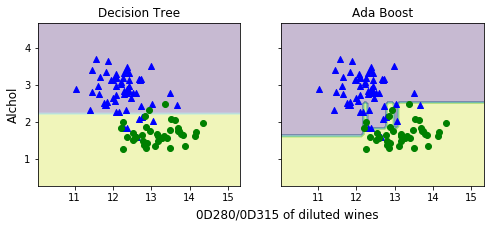

In [72]:
fig, ax = plt.subplots(ncols=2, nrows=1, sharex='col', sharey='row', figsize = (8,3))

for idx, clf, tt in zip([0,1], [tree, ada], ['Decision Tree','Ada Boost']):
    Z = clf.predict(np.array([xx.ravel(), yy.ravel()]).T)
    Z = Z.reshape(xx.shape)
    
    ax[idx].contourf(xx, yy, Z, alpha = 0.3)
    ax[idx].scatter(X_train[y_train==0,0], X_train[y_train==0,1], c= 'blue', marker = '^')
    ax[idx].scatter(X_train[y_train==1,0], X_train[y_train==1, 1],  c= 'green', marker = 'o')
    ax[idx].set_title(tt)

ax[0].set_ylabel('Alchol', fontsize = 12)
plt.text(10.2, -0.5, s= '0D280/0D315 of diluted wines', ha='center', va='center', fontsize = 12)
plt.show()

By looking at the decision regions, we can see that the decision boundary of the AdaBoost model is substantially more complex than the decision boundary of the decision stump. In addition, we note that AdaBoost model seperates the feature space very similarly to the bagging classifier that we trained in the previous section.

In Future this notebook will also contain information and examples on other boosting methods like

- Gradient Boost
- Extreme Gradient Boost
- LgBoost


**NOTE --------------**

Ensemble learning increases the computational complexity compared to individual classifiers. So In practice it will not be coming in a lot of use since we need cost efficient model. But this approach can be good for competition like kaggle and others where we need to outperform other by achieveing the highest accuracy possible on unseen data.